In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_curve, auc
from neurovlm.data import data_dir, load_masker, load_dataset
from neurovlm.models import load_model
from neurovlm.train import which_device

In [4]:
# Load models
device = which_device()
autoencoder = load_model("autoencoder").to(device).eval()
masker = load_masker()

# Load vectors from 01_coordinate.ipynb
neuro_vectors, pmids = torch.load(
    data_dir / "neuro_vectors.pt", weights_only=False,
).values()

train, test, val = torch.load(data_dir / "pmids_split.pt", weights_only=False).values()

In [55]:
# PubMed
X_pubmed = neuro_vectors[pd.Series(pmids).isin(test)].to(device)
with torch.no_grad():
    X_pubmed_re = autoencoder(X_pubmed)
X_pubmed = X_pubmed.to("cpu")
X_pubmed_re = X_pubmed_re.to("cpu")

# Neurovault
nv = torch.load(data_dir / "neurovault.pt", weights_only=False)
df_pubs = nv["df_pubs"]
assert not pd.Series(train).isin(df_pubs["doi"]).any()

X_nv = torch.from_numpy(nv["neuro_clustered"]).to(device)
X_nv = (X_nv > 0).float()
# X_nv = nv["neuro"].to(device)
with torch.no_grad():
    X_nv_re = autoencoder(X_nv)
X_nv = X_nv.to("cpu")
X_nv_re = X_nv_re.to("cpu")

In [56]:
def bernoulli_bce(y, p, eps=1e-7):
    """Elementwise Bernoulli negative log-likelihood (cross-entropy), in nats."""
    p = np.clip(p, eps, 1 - eps)
    y = np.clip(y, 0.0, 1.0)
    return -(y * np.log(p) + (1 - y) * np.log(1 - p))

def eval_recon_bpp(y_true, logits, *, baseline="per_pixel", eps=1e-7):
    """
    y_true: (N, D) floats in [0,1]
    logits: (N, D) raw logits from decoder (before sigmoid)

    Returns dict with:
      - bpp_model_per_image
      - bpp_base_per_image
      - delta_bpp_per_image (base - model)
      - delta_bpp_per_pixel (mean over N, in bits)  # for a skill map
    """
    y_true = np.asarray(y_true)
    logits = np.asarray(logits)
    assert y_true.shape == logits.shape, f"shape mismatch: {y_true.shape} vs {logits.shape}"
    N, D = y_true.shape

    p = 1 / (1 + np.exp(-logits)) # sigmoid(logits)

    # Model BCE per image (mean over pixels), then to bits
    bce_model = bernoulli_bce(y_true, p, eps=eps).mean(axis=1)  # (N,)
    bpp_model = bce_model / np.log(2)

    # Baseline probabilities
    if baseline == "global":
        p0 = float(y_true.mean())
        p_base = np.full((N, D), p0, dtype=np.float64)
    elif baseline == "per_pixel":
        p0 = y_true.mean(axis=0, keepdims=True)  # (1, D)
        p_base = np.repeat(p0, repeats=N, axis=0)  # (N, D)
    else:
        raise ValueError("baseline must be 'global' or 'per_pixel'")

    bce_base = bernoulli_bce(y_true, p_base, eps=eps).mean(axis=1)  # (N,)
    bpp_base = bce_base / np.log(2)

    delta_bpp = bpp_base - bpp_model  # (N,) improvement over baseline, bits/pixel

    # Per-pixel skill map (average improvement over images)
    bce_model_px = bernoulli_bce(y_true, p, eps=eps)          # (N, D)
    bce_base_px  = bernoulli_bce(y_true, p_base, eps=eps)     # (N, D)
    delta_bpp_px = (bce_base_px - bce_model_px).mean(axis=0) / np.log(2)  # (D,)

    return dict(
        bpp_model_per_image=bpp_model,
        bpp_base_per_image=bpp_base,
        delta_bpp_per_image=delta_bpp,
        delta_bpp_per_pixel=delta_bpp_px,
        baseline=baseline,
    )

In [57]:
def compute_performance(X, X_re):
    fpr, tpr, _ = roc_curve(
        X.numpy().reshape(-1) > 0.5,
        torch.sigmoid(X_re).numpy().reshape(-1)
    )
    roc_auc = auc(fpr, tpr)

    res = eval_recon_bpp(X, X_re, baseline="per_pixel")

    delta = res["delta_bpp_per_image"]
    bpp_base = res["bpp_base_per_image"]

    pct = 100.0 * (delta / np.clip(bpp_base, 1e-12, None))

    return fpr, tpr, pct, roc_auc

fpr_pm, tpr_pm, pct_pm, roc_auc_pm = compute_performance(X_pubmed, X_pubmed_re)
fpr_nv, tpr_nv, pct_nv, roc_auc_nv = compute_performance(X_nv, X_nv_re)

/tmp/ipykernel_701/2960777046.py:23: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-logits)) # sigmoid(logits)
/tmp/ipykernel_701/2960777046.py:23: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-logits)) # sigmoid(logits)


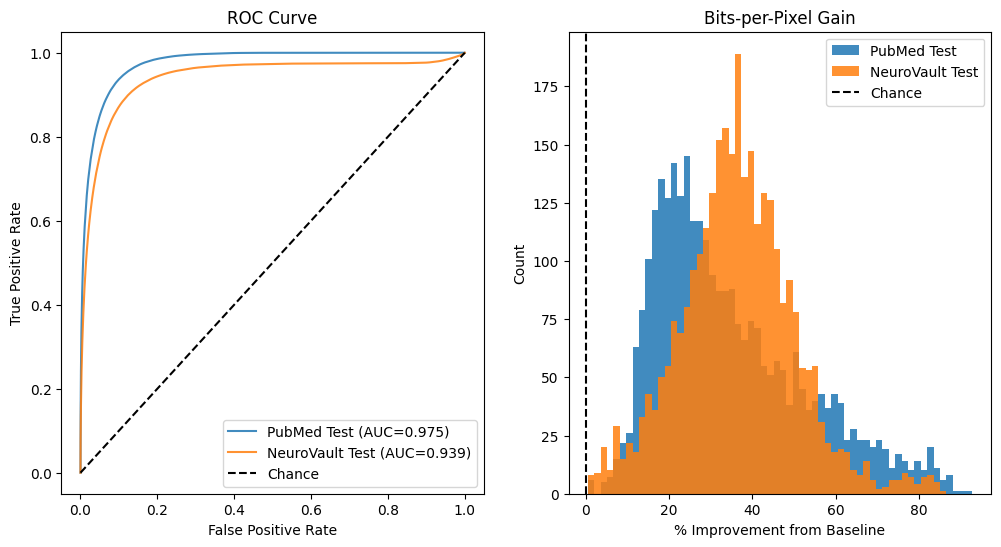

In [68]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

axes[0].plot(fpr_pm[::1000], tpr_pm[::1000], alpha=0.85, label=f"PubMed Test (AUC={roc_auc_pm:.3f})")
axes[0].plot(fpr_nv[::1000], tpr_nv[::1000], alpha=0.85, label=f"NeuroVault Test (AUC={roc_auc_nv:.3f})")
axes[0].plot([0, 1], [0, 1], color='k', ls='--', label='Chance')
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend()

_, bins, _ = axes[1].hist(pct_pm, bins=60, alpha=0.85, label=f"PubMed Test")
axes[1].hist(pct_nv, alpha=0.85, bins=bins, label=f"NeuroVault Test")
axes[1].axvline(0.0, linestyle="--", color='k', label="Chance")
axes[1].set_xlabel("% Improvement from Baseline")
axes[1].set_ylabel("Count")
axes[1].set_title("Bits-per-Pixel Gain")
axes[1].legend()

plt.savefig(data_dir / "autoencoder_perf.png", dpi=300)